# Lab 2 - BCC406/PCC177

## REDES NEURAIS E APRENDIZAGEM EM PROFUNDIDADE

## Regressão Logística

### Prof. Eduardo e Prof. Pedro

Objetivos:

- Regressão Logística.

Data da entrega : 24/10

- Complete o código (marcado com 'ToDo') e quando requisitado, escreva textos diretamente nos notebooks. Onde tiver *None*, substitua pelo seu código.
- Execute todo notebook e salve tudo em um PDF **nomeado** como "NomeSobrenome-LabX.pdf"
- Envie o PDF via google [FORM](https://forms.gle/iX2q4iyY8kYDrsJq7)
- Envie o *.ipynb* também.



## Classificador Binário com Regressão Logística

Você criará um classificador baseado em regressão logística para reconhecer gatos em imagens.

**Dica:**
- Evite loops (for / while) em seu código. Isso o tornará mais eficiente.

**Notebook para:**
- Construir a arquitetura geral de um algoritmo regressão logística, incluindo:
     - Inicializando parâmetros
     - Cálculo da função de custo e seu gradiente
     - Algoritmo de otimização - gradiente descendente


### Preparação do ambiente


---



Primeiro precisamos importar os pacotes. Vamos executar a célula abaixo para importar todos os pacotes que precisaremos.
- [*numpy*](www.numpy.org) é o pacote fundamental para a computação científica com Python.
- [*h5py*](http://www.h5py.org) é um pacote comum para interagir com um conjunto de dados armazenado em um arquivo H5.
- [*matplotlib*](http://matplotlib.org) é uma biblioteca famosa para plotar gráficos em Python.
- [*PIL*](http://www.pythonware.com/products/pil/) e [*scipy*](https://www.scipy.org/) são usados aqui para carregar as imagens e testar seu modelo final.
- *np.random.seed(1)* é usado para manter todas as chamadas de funções aleatórias.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

O próximo passo é configurar o *matplotlib* e a geração de valores aleatórios.

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

Configurando o Google Colab.

In [3]:
# Você vai precisar fazer o upload dos arquivos no seu drive (faer na pasta raiz) e montá-lo
# não se esqueça de ajustar o path para o seu drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Entendendo o problema (1pt)


---



O problema a ser tratado é o de classificar imagens em duas classes: tem um gato ou não tem um gato.

Há dois conjuntos de dados: *train_catvnoncat.h5* e *test_catvnoncat.h5*. Cada conjunto contem:

- um conjunto de imagens rotuladas como gato ($y = 1$) ou sem-gato ($y = 0$)
- cada imagem tem a forma (*num_px*, *num_px*, *num_ch*), em que *num_ch* é relativos aos canais de cores (RGB) e deve ser fixado em **3**. Assim, cada imagem é quadrada (altura = *num_px*) (largura = *num_px*) e colorida.


Repare que temos um conjunto para o treinamento dos modelos (ajuste dos parâmetros) e outro conjunto chamado de teste, que serve para avaliação do modelo. Ou seja, como meu modelo vai se comportar com dados que não participaram do processo de treinamento.


Carregue os dados executando o seguinte código.

In [4]:
# Função para ler os dados (gato/não-gato)
def load_dataset():

  train_dataset = h5py.File('drive/MyDrive/datasets/train_catvnoncat.h5', "r")
  train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
  train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

  test_dataset = h5py.File('drive/MyDrive/datasets/test_catvnoncat.h5', "r")
  test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
  test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

  classes = np.array(test_dataset["list_classes"][:]) # the list of classes
  train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
  test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

  return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [5]:
# Lendo os dados (gato/não-gato)
treino_x_orig, treino_y, teste_x_orig, teste_y, classes = load_dataset()

O termo `_orig` no final dos conjuntos de dados (treino e teste) significa que estamos tratando com os dados lidos originalmente. Após o pré-processamento, atribuiremos a outros objetos (`treino_x` e `teste_x`).


Cada linha de `treino_x_orig` e `teste_x_orig` é uma matriz que representa uma imagem. Você pode visualizar um exemplo executando o seguinte código.


y = [1], é uma figura 'cat' 


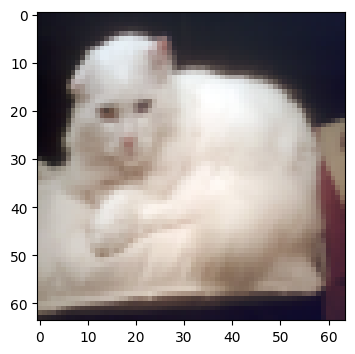

In [6]:
# Exemplo
index = 13
plt.imshow(treino_x_orig[index])
print ("y = " + str(treino_y[:, index]) + ", é uma figura '" + classes[np.squeeze(treino_y[:, index])].decode("utf-8") +  "' ")

Mas quantos dados temos?

In [7]:
print (f'Formato de treino_x: {treino_x_orig.shape}')
print (f'formato de treino_y: {treino_y.shape}')
print (f'formato de teste_x: {teste_x_orig.shape}')
print (f'formato de teste_y: {teste_y.shape}')

Formato de treino_x: (209, 64, 64, 3)
formato de treino_y: (1, 209)
formato de teste_x: (50, 64, 64, 3)
formato de teste_y: (1, 50)


**ToDo:** Defina os valores para: (1pt)

* `m_treino`: número de exemplos de treinamento.
* `m_teste`: número de exemplos de teste.
* `num_px`: altura = largura de uma imagem de treinamento.


**DICA**: você tems estes valores nas dimensões dos tensores `treino_x_orig` e `treino_y_orig`




In [8]:
m_treino = 209
m_teste = 50
num_px = 64

### Pré-processando os dados (2pt)


---



Nesse ponto vamos preparar os dados para que sejam usados no treinamento. Para isso precisamos adaptar o formato dos dados (vetorização) e normalizá-los.

Na vetorização iremos converter a imagem 3D (64 $\times$64$\times$3) em um único vetor 1D (12288 = 64$\times$64$\times$3). A figura mostra um exemplo do pré-processamento executado (imagem vetorizada).

Já na normalização, colocaremos os dados em um intervalo desejado, para este trabalho será [0.0, 1.0].

![Arq,widht=10](https://drive.google.com/uc?export=view&id=1zCnEB2rwc4lXU_7RTS4TXhqCwsJubg7H)

<caption><center> <u>Figura</u>: Vetorização de uma imagem. <br> </center></caption>

#### Vetorização (1pt)

Por conveniência, vamos "**vetorizar**" as imagens para que elas fiquem nas dimensões: `(num_px * num_px * 3, 1)`. Depois disso, nosso conjunto de dados de treinamento (e teste) será uma matriz `ndarray(numpy)` em que cada coluna representa uma imagem vetorizada. Deve haver `m_treino` colunas. O mesmo para o conjunto de teste, contudo com `m_teste` colunas.

In [9]:
# Formate o conjunto de treinamento e teste dados de treinamento e teste para que as imagens
# de tamanho (num_px, num_px, 3) sejam vetores de forma (num_px * num_px * 3, 1)
#    **dica**: ver documentação da função reshape(..)
treino_x_vet = treino_x_orig.reshape((treino_x_orig.shape[0], num_px * num_px * 3)).T
teste_x_vet = teste_x_orig.reshape((teste_x_orig.shape[0], num_px * num_px * 3)).T

print (f'Formato de treino_x_vet: {treino_x_vet.shape}')
print (f'Formato de treino_y: {treino_y.shape}')
print (f'Formato de teste_x_vet: {teste_x_vet.shape}')
print (f'Formato de teste_y: {teste_y.shape}')

Formato de treino_x_vet: (12288, 209)
Formato de treino_y: (1, 209)
Formato de teste_x_vet: (12288, 50)
Formato de teste_y: (1, 50)


#### Normalização (1pt)

As imagens do conjunto de dados são repreesentadas por canais (RGB). Os canais vermelho, verde e azul devem ser especificados para cada pixel e, portanto, o valor do pixel é na verdade um vetor de três números que variam de 0 a 255.

Uma etapa comum de pré-processamento no aprendizado de máquina é centralizar e normalizar seu conjunto de dados, que significa subtrair cada exemplo pela média do conjunto todo e dividir pelo desvio padrão (de toda a matriz de dados de treino). Porém, para conjuntos de dados de imagens, é mais simples e conveniente apenas dividir cada pixel por 255 (o valor máximo).

Vamos normalizar o conjunto de dados, dexando os valores dos pixels entre 0 e 1.

In [10]:
# Normalize os dados (colocar no intervalo [0.0, 1.0])
print (f'Valores de treino_x, antes: \n {treino_x_vet}\n')

treino_x = treino_x_vet / 250
teste_x = teste_x_vet / 250

print (f'Valores de treino_x, depois: \n {treino_x}')

Valores de treino_x, antes: 
 [[ 17 196  82 ... 143  22   8]
 [ 31 192  71 ... 155  24  28]
 [ 56 190  68 ... 165  23  53]
 ...
 [  0  82 138 ...  85   4   0]
 [  0  80 141 ... 107   5   0]
 [  0  81 142 ... 149   0   0]]

Valores de treino_x, depois: 
 [[0.068 0.784 0.328 ... 0.572 0.088 0.032]
 [0.124 0.768 0.284 ... 0.62  0.096 0.112]
 [0.224 0.76  0.272 ... 0.66  0.092 0.212]
 ...
 [0.    0.328 0.552 ... 0.34  0.016 0.   ]
 [0.    0.32  0.564 ... 0.428 0.02  0.   ]
 [0.    0.324 0.568 ... 0.596 0.    0.   ]]


### Arquitetura da rede e o algoritmo de aprendizado

---



A figura a seguir explica o porquê **a regressão logística é realmente uma rede neural muito simples!**

![Arq,widht=200](https://drive.google.com/uc?export=view&id=16lfjW5R0BMWrGMLY2j3pRvQ_16ttDJRe)


**Expressão matemática do algoritmo**:

Para um exemplo $x^{(i)}$:

$$z^{(i)} = w^T x^{(i)} + b \tag{1},$$
$$\hat{y^{(i)}} = a^{(i)} = sigmoid(z^{(i)})\tag{2},$$
$$L(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3},$$

onde:
 - $z^{(i)}$ é a saída cálculo entre a multiplicação dos pesos e dos valores de entrada mais o *bias*.
 - $x^{(i)}$ é o seu vetor de entrada, sendo $x_k^{(i)}$ o valor de cada pixel.
 - $w$ é o seu vetor de pesos (vem do inglês: weights).
 - $b$ é o seu viés (vem do inglês: bias).
 - $y^{(i)}$ é a saída esperada para o vetor de entrada $x^{(i)}$.
 - $\hat{y^{(i)}}$ e $a^{(i)}$ são a saída da sua rede dada a entrada $x^{(i)}$.
 - $L(a^{(i)}, y^{(i)})$ é o *loss* dada a entrada $x^{(i)}$.
 - *sigmoid* e *log* são funções matemáticas.

O custo é então calculado somando sobre todos os exemplos do treinamento:

$$J = \frac{1}{m} \sum_{i=1}^m L(a^{(i)}, y^{(i)})\tag{6},$$

onde $m$ é o conjunto de imagens de um lote.

**Etapas principais**:

Neste exercício, você executará as seguintes etapas:

- Inicializar os parâmetros do modelo
- Aprender os parâmetros do modelo, minimizando o custo
- Use os parâmetros aprendidos para fazer a predição (no conjunto de testes)
- Analisar os resultados.

### Criando o código para treinar o modelo (79pt)


---



Agora que entendemos a arquitetura da rede (uma única camada oculta e uma camada de saída), precisamos criar as funções para inicializar os pesos, *sigmoid* e de custo.

#### Inicialização dos pesos (4pt)

O modelo precisa que os seus pesos sejam inicializados. Essa inicialização pode ser feita gerando os pesos aleatoriamente ou com valores zerados dada uma dimensão.

Para testarmos, começaremos inicializando o vetor $w$ e $b$ como zero dada uma dimensão `dim`.

In [28]:
# Função que inicializa w e b
#   **dica**: veja a função np.zeros(..)

def inicialize(dim):
    """
    Inicializa um vetor de tamanho (dim, 1) para w and  b = 0.

    Entrada:
      dim -- tamanho de w (número de parâmetros)
    Saída:
      w -- tamanho (dim, 1)
      b -- um escalar (correspondente ao bias)
    """

    # ToDo: criar um vetor zero com a dimensão (dim, 1)
    w = np.zeros((dim, 1))
    # ToDo: inicializar com o valor correto
    b = 0

    # Verificando se o retorno da função está de acordo com o esperado
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))

    return w, b

Agora vamos testar a função `inicialize()`. Para isso, passaremos o valor de `dim` como sendo 2.

Os valores esperados são:

<table style="width:15%">
    <tr>
        <td>  ** w **  </td>
        <td> [[ 0.] [ 0.]] </td>
    </tr>
    <tr>
        <td>  ** b **  </td>
        <td> 0 </td>
    </tr>
</table>


In [29]:
dim = 2
w, b = inicialize(dim)
print(f'w = \n {w}')
print(f'b = {b}')

w = 
 [[0.]
 [0.]]
b = 0


#### *Sigmoid* (10pt)

A *sigmoid* é uma função matemática com o formato de uma curva em "S" ou curva sigmoide. Ela transforma qualqer valor de um domínio $(-\infty, +\infty)$ para um número no intervalo 0 e 1.

Como você viu na figura acima, você precisa calcular $sigmoid (w^T x + b) = \frac {1} {1 + e^{- (w^T x + b)}}$ para fazer previsões.

In [13]:
# Faça a função de ativação sigmoid
#    **dica**: você pode usar a função exponencial do numpy (np.exp(-z))

def sigmoid(z):
    """
    Calcula a sigmoid de z

    Entrada:
      z -- Um escalar ou um numpy array de qualquer tamanho.
    Saída:
      s -- sigmoid(z)
    """
    # ToDo: implemente a função sigmoide
    s = 1 / (1 + np.exp(-z))
    return s

Agora vamos testar a função `sigmoid()`. Para isso, passaremos dois valores de teste (0 e 2).

Os valores esperados são:

<table>
  <tr>
    <td> 0 </td><td> 0.5 </td>
  </tr>
  <tr>
    <td> 2 </td><td> 0.88079708 </td>
  </tr>
</table>

Observe que a função aplica a função `sigmoid` para elemento de z.


In [14]:
print (f'sigmoid([0, 2]) = {sigmoid(np.array([0,2]))}')

sigmoid([0, 2]) = [0.5        0.88079708]


#### Função de custo (10pt)

O objetivo da função de custo é calcular o erro ou a discrepância entre o que foi predito e o valor real.

Como já foi visto, você precisa calcular

$$J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)}).$$

In [15]:
# Faça a função para calcular o custo J
#   **dica**: você pode usar a função np.log(..)

def custo(Y, A):
    """
    Calcula o custo J considerando Y e A.

    Entrada:
      Y -- Um escalar ou um numpy array de qualquer tamanho com o valor real.
      A -- Um escalar ou um numpy array de qualquer tamanho com o valor predito.
    Saída:
      c -- custo considerando Y e A

      Um função de custo melhor:
      Loss = - [ Y log(Ypred) + (1-Y) log(1-Ypred) ]

    """
    # ToDo: implemente a função de custo J. **dica** : utilize a função np.log()
    c = -1/(Y.shape[0]) * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))
    return c

Agora vamos testar a função `custo()`. Para isso, faremos alguns testes:

 - Passaremos dois valores para `Y` (0 e 1) e dois para `A` (0.1 e 0.9). O valor esperado é de 0.10536051565782628.
 - Passaremos dois valores para `Y` (0 e 1) e dois para `A` (0.1 e 0.1). O valor esperado é de 1.203972804325936.
 - Passaremos dois valores para `Y` (0 e 1) e dois para `A` (0.9 e 0.9). O valor esperado é de 1.2039728043259361.
 - Passaremos dois valores para `Y` (0 e 1) e dois para `A` (0.9 e 0.1). O valor esperado é de 2.302585092994046.
 - Passaremos dois valores para `Y` (0 e 1) e dois para `A` (0.5 e 0.5). O valor esperado é de 0.6931471805599453.




In [16]:
print(f'custo([0.0, 1.0], [0.1, 0.9]) = {custo(np.array([0.0, 1.0]), np.array([0.1, 0.9]))}')
print(f'custo([0.0, 1.0], [0.1, 0.1]) = {custo(np.array([0.0, 1.0]), np.array([0.1, 0.1]))}')
print(f'custo([0.0, 1.0], [0.9, 0.9]) = {custo(np.array([0.0, 1.0]), np.array([0.9, 0.9]))}')
print(f'custo([0.0, 1.0], [0.9, 0.1]) = {custo(np.array([0.0, 1.0]), np.array([0.9, 0.1]))}')
print(f'custo([0.0, 1.0], [0.5, 0.5]) = {custo(np.array([0.0, 1.0]), np.array([0.5, 0.5]))}')

custo([0.0, 1.0], [0.1, 0.9]) = 0.10536051565782628
custo([0.0, 1.0], [0.1, 0.1]) = 1.203972804325936
custo([0.0, 1.0], [0.9, 0.9]) = 1.2039728043259361
custo([0.0, 1.0], [0.9, 0.1]) = 2.302585092994046
custo([0.0, 1.0], [0.5, 0.5]) = 0.6931471805599453


#### Propagação dos valores pelo modelo e cálculo do gradiente (20pt)

Dada as entradas e os pesos, deve-se realizar a propagação dos dados pela rede considerando os seus pesos e logo depois a retropropagação das derivadas. Para isso, devemos implementar a função `propagacao ()` que calcula a função de custo e seu gradiente.

O processo pode ser dividido em dois passos principais: **Forward-Propagation** e **Backward-propagation**.

**Forward-Propagation:**
  - Multiplique a entrada $X$ pelo vetor de pesos
  - Calcule a ativação
      
      $$A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$$

  - Calcule a função de custo:
      
      $$J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$$

**Backward-propagation:**
  - Cálculo do gradiente para o vetor de pesos $w$:
      
      $$\frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$

  - Cálculo do gradiente para o bias $b$:
      
      $$\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [ ]:
def propagacao(w, b, X, Y):
    """
    Implementa a função custo e seus gradientes

    Entrada:
      w -- pesos, de tamanho (num_px * num_px * 3, 1)
      b -- bias, um escalar
      X -- dados de treinamentos de tamanho (num_px * num_px * 3, número de exemplos)
      Y -- (0 se não-gato, 1 se gato) de tamanho (1, número de exemplos)
    Saída:
      custo -- custo para regressão logística
      dw -- gradiente da função loss em relação a w
      db -- gradiente da função loss em relação a b
    """

    # Número de exemplos
    m = X.shape[1]

    # Propagação da imagem pela rede
    A = sigmoid(np.dot(w.T, X) + b)

    # Cálculo do custo
    custo = -1/m * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))

    # Cálculo dos gradientes
    dw = 1/m * np.dot(X, (A - Y).T)
    db = 1/m * np.sum(A - Y)

    custo = np.squeeze(custo)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    assert(custo.shape == ())

    grads = {"dw": dw, "db": db}

    return grads, custo


Agora vamos testar a função `propagacao()`. Para isso, passaremos o vetor de pesos, o valor de bias, os dados de treino e os labels, ou seja, os dados que uma camada oculta precisa receber.

Os valores esperados são:

<table style="width:50%">
    <tr>
        <td> <b>dw</b> </td>
        <td> [ [ 0.99845601 ] [ 2.39507239 ] ]</td>
    </tr>
    <tr>
        <td> <b>db</b> </td>
        <td> 0.00145557813678 </td>
    </tr>
    <tr>
        <td> <b>custo</b> </td>
        <td> 5.801545319394553 </td>
    </tr>

</table>

In [20]:
# Teste
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, custo = propagacao(w, b, X, Y)
print (f'dw = {grads["dw"]}')
print (f'db = {grads["db"]}')
print (f'custo = {custo}')

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
custo = 5.801545319394553


#### Otimização dos pesos e descida do gradiente (25pt)

O processo de atualização dos parâmetros é de extrema importância, pois é ele que vai corrigir os pesos baseado no erro encontrado nos dados de teste. Esse processo é realizado pelo algoritmo da descida do gradiente.

O algoritmo visa atualizar os valores de $w$ e $b$, minimizando a função de custo $J$. Para um parâmetro $ \theta $, a regra de atualização é dada por

$$\theta = \theta - \alpha \text{ } d\theta,$$

em que $\alpha$ é a taxa de aprendizado.

In [21]:
def gradiente_descendente(w, b, X, Y, num_iter, learning_rate, print_custo=False):
    """
    Esta função atualiza/otimiza os parâmetros w e b através do algoritmo do gradiente

    Entrada:
      w -- pesos, de tamanho (num_px * num_px * 3, 1)
      b -- bias, um escalar
      X -- dados de treinamento de tamanho (num_px * num_px * 3, número de exemplos)
      Y -- (0 se não-gato, 1 se gato) de tamanho (1, número de exemplos)
      num_iter -- número de iterações
      learning_rate -- taxa de aprendizagem do algoritmo de gradiente descendente
      print_custo -- flag para impressão do custo
    Saída:
      params -- dicionário contendo os pesos w e bias b
      grads -- dicionário contendo os gradientes dos pesos w e bias b em relação à função de custo
      custos -- lista de todos os custos durante a otimização, usada para plotar a curva de aprendizado.
    """

    custos = []
    m = X.shape[1]

    for i in range(num_iter):
        grads, custo = propagacao(w, b, X, Y)

        dw = grads["dw"]
        db = grads["db"]

        w = w - learning_rate * dw
        b = b - learning_rate * db

        if i % 100 == 0:
            custos.append(custo)

        if print_custo and i % 100 == 0:
            print(f"Custo após {i:4d} iterações: {custo:.4f}")

    params = {"w": w, "b": b}
    grads = {"dw": dw, "db": db}

    return params, grads, custos


Agora vamos testar a função `gradiente_descendente()`. Os valores esperados são:

<table style="width:40%">
    <tr>
       <td> <b>w</b> </td>
       <td>[[ 0.19033591 ] [ 0.12259159 ]] </td>
    </tr>
    <tr>
       <td> <b>b</b> </td>
       <td> 1.92535983008 </td>
    </tr>
    <tr>
       <td> <b>dw</b> </td>
       <td> [[ 0.67752042 ][ 1.41625495 ]] </td>
    </tr>
    <tr>
       <td> <b>db</b> </td>
       <td> 0.219194504541 </td>
    </tr>
</table>

In [22]:
params, grads, custos = gradiente_descendente(w, b, X, Y, num_iter= 100, learning_rate = 0.009, print_custo = False)

print (f'w = {params["w"]}')
print (f'b = {params["b"]}')
print (f'dw = {grads["dw"]}')
print (f'db = {grads["db"]}')

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067657


#### Predição do modelo (10pt)

Depois que o modelo é treinado, ou seja, houve o aprendizado (otimização) dos parâmentros w e b, eles são usados para predizer os rótulos para um conjunto de dados X.

O objetivo agora é implementar a função `predicao ()`. Para isso, deve-se:
  - Calculae
    $$ \hat{Y} = A = \sigma(w^T X + b) $$
  - Converter $\hat{Y}$ em 0 (se ativação $\leq$ 0,5) ou 1 (se ativação > 0,5).

In [23]:
def predicao(w, b, X):
    '''
    Prediz se o rótulo é 0 ou 1 usando os parâmetros de aprendizagem (w,b) da regressão logística

    Entrada:
      w -- pesos, de tamanho (num_px * num_px * 3, 1)
      b -- bias, um escalar
      X -- dados de treinamentos de tamanho (num_px * num_px * 3, número de exemplos)
    Saída:
      Y_pred -- um vetor contendo todas as predições (0/1) para os dados X
    '''

    m = X.shape[1]  # Número de exemplos
    Y_pred = np.zeros((1, m))  # Inicialize o vetor de predições com zeros

    A = sigmoid(np.dot(w.T, X) + b)  # Calcula as probabilidades A usando a função sigmoid

    # Converta as probabilidades em previsões binárias
    Y_pred = (A > 0.5).astype(int)

    assert(Y_pred.shape == (1, m))

    return Y_pred


Para testar a função `predicao`, devemos passar o vetor de pesos $w$, o bias $b$ e uma entrada. Os valores esperados são:

<table style="width:30%">
    <tr>
         <td>
             <b>predições</b>
         </td>
          <td>
            [[ 1.  1.  0.]]
         </td>  
   </tr>

</table>

In [24]:
# Teste
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print (f'Predições = {predicao(w, b, X)}')

Predições = [[1 1 0]]


### Criando e treinando o modelo (15pt)


---



Agora que temos as funções para treinar o modelo, podemos criar uma função que junta todas as outras funções para criar e treinar o modelo de treinamento.


O objetivo é construir o modelo, usando a seguinte notação:

  - `Y_pred_teste` para suas previsões no conjunto de testes
  - `Y_pred_treino` para suas previsões no treino
  - `w`, `custos`, `grads` para as saídas do algoritmo `gradiente()`.

In [30]:
def treinar_modelo(X_treino, Y_treino, X_teste, Y_teste, num_iter=5000, learning_rate=0.5, print_custo=False):
    """
    Cria o modelo de regressão logística chamando as funções auxiliares

    Entradas:
      X_treino -- conjunto de treinamento representado por uma matriz numpy da forma (num_px * num_px * 3, m_treino)
      Y_treino -- rótulos de treinamento representados por uma matriz numpy (vetor) da forma (1, m_treino)
      X_teste -- conjunto de teste representado por uma matriz numpy da forma (num_px * num_px * 3, m_teste)
      Y_teste -- rótulos de teste representados por uma matriz numpy (vetor) da forma (1, m_teste)
      num_iter -- hiperparâmetro que representa o número de iterações para otimizar os parâmetros
      learning_rate -- hiperparâmetro que representa a taxa de aprendizado usada na regra de atualização do gradiente descendente
      print_custo -- Defina como true para imprimir o custo a cada 100 iterações
    Saída:
      d -- dicionário contendo informações sobre o modelo.
    """

    # Inicializar os parâmetros
    w, b = inicialize(X_treino.shape[0])

    # Calcular o gradiente descendente
    parametros, grads, custos = gradiente_descendente(w, b, X_treino, Y_treino, num_iter, learning_rate, print_custo)

    # Recuperar os parâmetros w e b do dicionário "parametros"
    w = parametros["w"]
    b = parametros["b"]

    # Computar predições para os conjuntos treino e teste
    Y_pred_teste = predicao(w, b, X_teste)
    Y_pred_treino = predicao(w, b, X_treino)

    # Imprimir acurácia do treino/teste
    print("treino acurácia: {} %".format(100 - np.mean(np.abs(Y_pred_treino - Y_treino)) * 100))
    print("teste acurácia: {} %".format(100 - np.mean(np.abs(Y_pred_teste - Y_teste)) * 100))

    d = {"custos": custos,
         "Y_pred_teste": Y_pred_teste,
         "Y_pred_treino": Y_pred_treino,
         "w": w,
         "b": b,
         "learning_rate": learning_rate,
         "num_iter": num_iter}

    return d


### Testando o modelo treinado (3pt)


---



A função `treinar_modelo` é a única necessária neste ponto, pois ela combina todas as demais criadas até aqui. Para o teste abaixo, espera-se os seguintes resultados:

<table style="width:40%">
    <tr>
        <td> <b>Custo depois da iteração 0</b> </td>
        <td> 0.693147 </td>
    </tr>
      <tr>
        <td> <center> . . . </center> </td>
        <td> <center> . . . </center> </td>
    </tr>  
    <tr>
        <td><b>Acurácia no treino</b></td>
        <td> 100 % </td>
    </tr>
    <tr>
        <td><b>Acurácia no teste</b></td>
        <td> 68.0 % </td>
    </tr>
</table>

***os valores não precisam ser exatos.***

In [31]:
d = treinar_modelo(treino_x, treino_y, teste_x, teste_y, num_iter=3000, learning_rate=0.01, print_custo=True)

Custo após    0 iterações: 0.6931
Custo após  100 iterações: 1.4150
Custo após  200 iterações: 0.3856
Custo após  300 iterações: 0.6042
Custo após  400 iterações: 0.5393
Custo após  500 iterações: 0.3996
Custo após  600 iterações: 0.2310
Custo após  700 iterações: 0.1495
Custo após  800 iterações: 0.1300
Custo após  900 iterações: 0.1198
Custo após 1000 iterações: 0.1115
Custo após 1100 iterações: 0.1045
Custo após 1200 iterações: 0.0984
Custo após 1300 iterações: 0.0929
Custo após 1400 iterações: 0.0880
Custo após 1500 iterações: 0.0836
Custo após 1600 iterações: 0.0797
Custo após 1700 iterações: 0.0760
Custo após 1800 iterações: 0.0727
Custo após 1900 iterações: 0.0696
Custo após 2000 iterações: 0.0668
Custo após 2100 iterações: 0.0642
Custo após 2200 iterações: 0.0618
Custo após 2300 iterações: 0.0595
Custo após 2400 iterações: 0.0574
Custo após 2500 iterações: 0.0555
Custo após 2600 iterações: 0.0536
Custo após 2700 iterações: 0.0519
Custo após 2800 iterações: 0.0503
Custo após 290

#### Usando o modelo treinado para classificar um imagem (1pt)

y = cat(1), o modelo predizeu que é um "non-cat" picture.


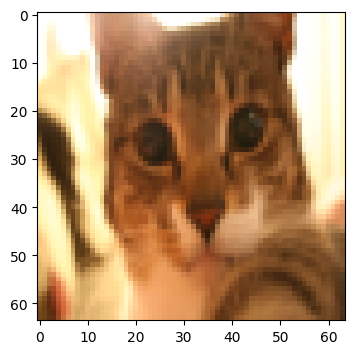

In [33]:
# Exemplos das predições
index = 11
plt.imshow(teste_x[:,index].reshape((num_px, num_px, 3)))
print (f'y = {classes[teste_y[0,index]].decode("utf-8")}({teste_y[0,index]}), o modelo predizeu que é um "{classes[int(d["Y_pred_teste"][0][index])].decode("utf-8")}" picture.')

**ToDo**: A acurácia no treinamento é próxima de 100%. Seu modelo está funcionando e tem capacidade alta o suficiente para ajustar os dados de treinamento. A acurácia no teste é de 68%. Porque tanta diferença?

```
 A diferença elevada indica overfitting, o modelo se ajustou demais aos dados de treinamento e não generalizando bem para os dados de teste.
```

 Plota a função custo e os gradientes

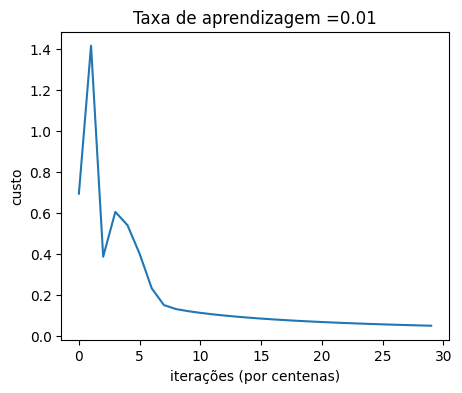

In [34]:
# Plot learning curve (with costs)
custos = np.squeeze(d['custos'])
plt.plot(custos)
plt.ylabel('custo')
plt.xlabel('iterações (por centenas)')
plt.title("Taxa de aprendizagem =" + str(d["learning_rate"]))
plt.show()

**Interpretação**:

Você pode ver o custo diminuindo. Isso mostra que os parâmetros estão sendo aprendidos. No entanto, você pode treinar o modelo ainda mais no conjunto de treinamento.

#### Avaliando o número de épocas de treinamento (1pt)

Vamos comparar a curva de aprendizado do modelo com várias opções de número de iterações. Execute a célula abaixo.

Iterações é: 500
treino acurácia: 82.77511961722487 %
teste acurácia: 82.0 %

-------------------------------------------------------

Iterações é: 1000
treino acurácia: 99.04306220095694 %
teste acurácia: 70.0 %

-------------------------------------------------------

Iterações é: 2000
treino acurácia: 99.52153110047847 %
teste acurácia: 70.0 %

-------------------------------------------------------

Iterações é: 3000
treino acurácia: 100.0 %
teste acurácia: 68.0 %

-------------------------------------------------------

Iterações é: 4000
treino acurácia: 100.0 %
teste acurácia: 68.0 %

-------------------------------------------------------



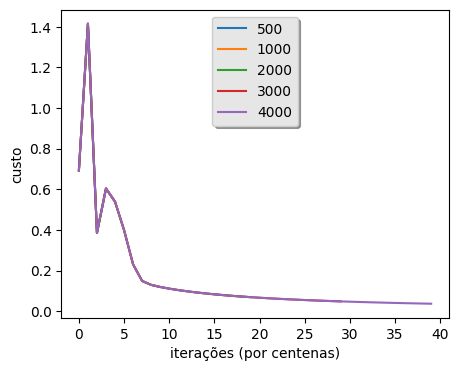

In [36]:
num_iters = [500, 1000, 2000, 3000, 4000]
modelos = {}
for i in num_iters:
    print ("Iterações é: " + str(i))
    modelos[str(i)] = treinar_modelo(treino_x, treino_y, teste_x, teste_y, num_iter=i, learning_rate=0.01, print_custo=False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in num_iters:
    plt.plot(np.squeeze(modelos[str(i)]["custos"]), label=str(modelos[str(i)]["num_iter"]))

plt.ylabel('custo')
plt.xlabel('iterações (por centenas)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Interpretação**:
- Diferentes número de épocas podem fornecer custos diferentes, contudo, dado um ponto, o custo não se altera no treinamento.
- Se o número de épocas for muito alto, o custo se estabiliza e o modelo não consegue aprender mais nada (isso pode ser impactado por outras variáveis). Se for baixo, o modelo ainda possui espaço para melhora que não foi explorado.

ToDo: O que acontece quando o número de iterações mudou? Explique

```
A acurácia de treino subiu muito pouco enquanto que a equivalente queda de acurácia de teste conforme aumentaram as iterações foi alarmante. Isso se deve pela efetiva estagnação do aprendizado entre 2mil e 3mil iterações, levando ao overfitting observado.
```

#### Avaliando a taxa de aprendizado (1pt)

**Lembrete**:
O algoritmo da descida do gradiente, depende da escolha da taxa de aprendizado. A taxa de aprendizado $ \alpha $ determina a rapidez com que atualizamos os parâmetros. Se a taxa de aprendizado for muito alta, podemos "ultrapassar" o valor ideal. Da mesma forma, se for muito pequeno, precisaremos de muitas iterações para convergir para os melhores valores. É por isso que é crucial usar uma taxa de aprendizado bem ajustada.

Vamos comparar a curva de aprendizado do modelo com várias opções de taxas de aprendizado. Execute a célula abaixo.

learning rate é: 0.025
treino acurácia: 100.0 %
teste acurácia: 68.0 %

-------------------------------------------------------

learning rate é: 0.0025
treino acurácia: 97.60765550239235 %
teste acurácia: 70.0 %

-------------------------------------------------------

learning rate é: 0.0001
treino acurácia: 72.2488038277512 %
teste acurácia: 46.0 %

-------------------------------------------------------



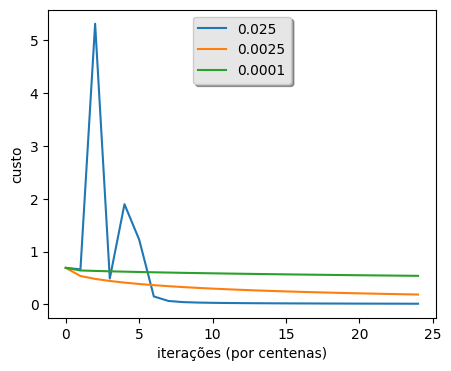

In [37]:
learning_rates = [0.025, 0.0025, 0.0001]
modelos = {}
for i in learning_rates:
    print ("learning rate é: " + str(i))
    modelos[str(i)] = treinar_modelo(treino_x, treino_y, teste_x, teste_y, num_iter = 2500, learning_rate = i, print_custo = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(modelos[str(i)]["custos"]), label= str(modelos[str(i)]["learning_rate"]))

plt.ylabel('custo')
plt.xlabel('iterações (por centenas)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Interpretação**:
- Diferentes taxas de aprendizado fornecem custos diferentes e, portanto, resultados de previsões diferentes.
- Se a taxa de aprendizado for muito alta (0,01), o custo poderá oscilar para cima e para baixo. Pode até divergir (embora, neste exemplo, o uso de 0,01 ainda termine com um bom valor para o custo).
- Um custo menor não significa um modelo melhor. Pode ocorrer o `overfitting`. Isso acontece quando a precisão do treinamento é muito maior que a precisão do teste.

ToDo: O que acontece quando o valor de learning rate mudou? Explique

```
 Com uma taxa alta de 0.025, o modelo se ajustou rápido e atingiu 100% de acurácia no treinamento, mas teve dificuldade em generalizar. Uma taxa intermediária de 0.0025 resultou em ajuste mais lento, com alta acurácia no treinamento (97.61%) e melhoria na generalização no teste (70%). Já abaixar a uma taxa de 0.0001 levou a ajuste muito lento, com acurácia razoável no treinamento (72.25%) mas baixa generalização no teste (46%).
```